In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.special as scsp
import sys
import sympy as sp
import mpmath as mp
import scipy.optimize as scop 
plt.style.use('seaborn-v0_8-darkgrid')
%run -i HA_integration.py

## Analysis in the Frequency Domain

This section delves into the behavior of the Laplace transform in the frequency domain. We begin by recapping the essential definitions and the integral representation derived in previous sections. We then transform this integral into the frequency domain, which reveals a powerful dual representation. This duality is leveraged to build a robust numerical computation strategy. Finally, we develop two distinct analytical approximations: one based on the saddle-point method, which is accurate for large transform arguments, and another asymptotic series tailored for small arguments.

### 1. A Brief Summary of the Problem Formulation

Let $X$ be a lognormally distributed random variable, $X \sim \mathrm{LogN}(\mu, v)$, meaning its logarithm $Y = \log X$ follows a normal distribution, $Y \sim \mathcal{N}(\mu, v)$. For convenience, we use the standard deviation $\sigma = \sqrt{v}$.

The Laplace transform of $X$, denoted $\mathcal{L}(u;\mu,v) = \operatorname{E}[e^{-uX}]$, can be expressed as an integral over the underlying normal variable $Y$:
$$
\mathcal{L}(u;\mu,v) = \frac{1}{\sqrt{2\pi v}} \int_{-\infty}^{\infty} \exp\left( -u e^y - \frac{(y - \mu)^2}{2v} \right) dy.
$$
A key simplification arises from the scaling property $\mathcal{L}(u;\mu,v) = \mathcal{L}(u e^\mu; 0, v)$. This allows us to focus on the zero-mean case ($\mu=0$) without loss of generality. We denote this simplified transform as $L(a,v) \equiv \mathcal{L}(u;0,v)$.

Through a series of substitutions detailed in previous sections, this integral was transformed into a form suitable for Gauss-Hermite quadrature:
$$
L(a,v) = \frac{\exp\left( -v a^2 / 2 \right)}{\sqrt{2\pi}} \int_{-\infty}^{\infty} e^{f(x)} e^{-x^2/2} dx = L(a,v),
$$
where the function $f(x)$ and the parameter $a$ are defined as:
$$
\begin{align*}
f(x) &= a ( \sigma x - e^{\sigma x}) \\
a &= \frac{W(uv)}{v},
\end{align*}
$$
with $W(\cdot)$ being the principal branch of the Lambert W function. This form centers the non-Gaussian part of the integrand at $x=0$, which is highly advantageous for both numerical integration and asymptotic analysis.

### 2. The Frequency-Domain Integral Representation

To gain further insight, we now transition from the spatial domain (integration over $x$) to the frequency domain. This is achieved by representing the Gaussian kernel using its characteristic function, which is its inverse Fourier transform:
$$
\frac{1}{\sqrt{2\pi}} e^{-x^2/2} = \frac{1}{2\pi} \int_{-\infty}^{\infty} e^{-w^2/2} e^{iwx} dw.
$$
Substituting this into our expression for $L(a,v)$ yields a double integral:
$$
L(a,v) = \exp\left( -\frac{v a^2}{2} \right) \int_{-\infty}^{\infty} e^{f(x)} \left( \frac{1}{2\pi} \int_{-\infty}^{\infty} e^{-w^2/2} e^{iwx} dw \right) dx.
$$
By Fubini's theorem, we can change the order of integration, grouping the terms dependent on $x$:
$$
L(a,v) = \frac{\exp\left( -\frac{v a^2}{2} \right)}{2\pi} \int_{-\infty}^{\infty} e^{-w^2/2} \left( \int_{-\infty}^{\infty} e^{f(x)} e^{iwx} dx \right) dw.
$$
Let's evaluate the inner integral, which is the Fourier transform of $e^{f(x)}$:
$$
I(w) = \int_{-\infty}^{\infty} \exp( a(\sigma x - e^{\sigma x}) + iwx ) dx.
$$
We perform the substitution $t = e^{\sigma x}$, which implies $x = \frac{1}{\sigma}\ln t$ and $dx = \frac{1}{\sigma t} dt$. The integration limits $(-\infty, \infty)$ for $x$ become $(0, \infty)$ for $t$:
$$
I(w) = \int_{0}^{\infty} \exp\left( a(\ln t - t) + \frac{iw}{\sigma}\ln t \right) \frac{1}{\sigma t} dt.
$$
Combining the logarithmic terms in the exponent gives $\ln(t^{a + i\frac{w}{\sigma}}) - at$. The integral becomes:
$$
I(w) = \frac{1}{\sigma} \int_{0}^{\infty} t^{(a + i\frac{w}{\sigma}) - 1} e^{-at} dt.
$$
This integral is now in the form of Euler's integral representation for the Gamma function. To match the canonical form $\Gamma(s) = \int_0^\infty z^{s-1} e^{-z} dz$, we use a final substitution $z = at$, so $t=z/a$ and $dt=dz/a$:
$$
I(w) = \frac{1}{\sigma} \int_{0}^{\infty} \left(\frac{z}{a}\right)^{(a + i\frac{w}{\sigma}) - 1} e^{-z} \frac{dz}{a} = \frac{a^{-(a + i\frac{w}{\sigma})}}{\sigma} \int_{0}^{\infty} z^{(a + i\frac{w}{\sigma}) - 1} e^{-z} dz.
$$
The remaining integral is precisely $\Gamma(a + i\frac{w}{\sigma})$. Therefore, the inner integral evaluates to:
$$
I(w) = \frac{1}{\sigma a^{a + i\frac{w}{\sigma}}} \Gamma\left(a + i\frac{w}{\sigma}\right).
$$
Substituting this result back into our expression for the Laplace transform, we arrive at the final frequency-domain representation:
$$
\boxed{
L(a,v) = \frac{\exp\left( -\frac{v a^2}{2} \right)}{2\pi\sigma} \int_{-\infty}^{\infty} \frac{\Gamma(a+i\frac{w}{\sigma})}{a^{a+i\frac{w}{\sigma}}} e^{-w^2/2} dw.
}
$$

### 3. The Dual-Domain Method for Robust Numerical Integration

This analysis has yielded two distinct integral representations for the same Laplace transform, both structured for Gauss-Hermite quadrature:
$$
L(a,v) = \int_{-\infty}^{\infty} \underbrace{e^{a(\sigma x - e^{\sigma x})}}_{\text{Spatial domain kernel}} \frac{e^{-x^2/2}}{\sqrt{2\pi}} dx \quad \Leftrightarrow \quad L(a,v) = \int_{-\infty}^{\infty} \underbrace{\operatorname{Re}\left[\frac{1}{\sqrt{2\pi}}\frac{\Gamma(a+i\frac{w}{\sigma})}{a^{a+i\frac{w}{\sigma}}}\right]}_{\text{Frequency domain kernel}} \frac{e^{-w^2/2}}{\sqrt{2\pi}} dw.
$$
Note that since $L(a,v)$ must be real, the integral is equal to the integral of the real part of its integrand. The real part of the frequency-domain kernel is an even function of $w$, as can be shown using the property $\Gamma(\bar{z}) = \overline{\Gamma(z)}$.

This duality is not merely an analytical curiosity; it provides a powerful solution to a common numerical problem. For certain parameter values, the integrand in one domain can become highly concentrated around the origin, resembling a Dirac delta function. Standard quadrature methods may fail to capture the mass of such a sharply peaked function, leading to inaccurate results.

However, the spatial and frequency domain representations exhibit a reciprocal relationship, analogous to the uncertainty principle in Fourier analysis. When the integrand in one domain is narrow and sharply peaked, its counterpart in the other domain is wide and smooth. This allows for a robust adaptive numerical strategy:

1.  **Assess Both Kernels:** For a given set of parameters $(u, v)$, evaluate the width or flatness of the kernels in both the spatial and frequency domains. A simple heuristic is to measure their decay away from the origin.
2.  **Select the Optimal Domain:** Choose to perform the numerical integration in the domain where the kernel function is wider and smoother.
3.  **Integrate:** By always selecting the more numerically stable representation, we can achieve high accuracy using a fixed, and often small, number of quadrature nodes across all parameter regimes.

This adaptive approach effectively mitigates the issue of "delta-like" integrands, making the computation of the lognormal Laplace transform reliable and efficient.

In [2]:
def LTLN_DI_HA_real_uvF(n=36, h_g=True, toll=sys.float_info.epsilon/10. ): #higher accuracy for big u 
    '''
    Computes nodes and weights for std normal \exp(-x^2/2)/\sqrt(2\pi) integration
    then construct function to get the Laplace transform of log-normal variable
    '''
    if h_g and n < 110: #hermite gauss tested only up to 100 nodes and crashed after 180
        si, ws = hermite_gauss_scaled(n,toll)
    else:
        si, ws = takahasi_mori_stdnormal(n)    
    half_n=len(si)//2
    q_n=half_n//2
    fi, wf=si[:half_n], 2.*ws[:half_n] #half of nodes we must double wieghts

    def LTLN(u,v):
        '''
        Computes the Laplace transform at the point u,
        using precomputed Hermite–Gauss or Takahasi-Mori nodes  and weights .
        
        Arguments:
        - nodes and weights scaled on sqrt(2) and 1/sqrt(pi)
        - u: real-valued base magnitude of the argument
        - v: log-variance parameter of the lognormal distribution
        '''
        a = np.atleast_1d(np.real(scsp.lambertw(u*v))/v)
        σ = np.sqrt(v)
        
        def f_domain():
            a_ = a.flatten()[:,None]
            q=a_+(1j/σ)*fi[None,:]
            g=np.real(np.exp(-np.log(a_)*q)*scsp.gamma(q))
            scale=0.3989422804014327/σ # 0.3989422804014327 = 1/sqrt(2 pi)
            return np.dot(g, wf*scale ), np.abs(g[:,q_n])*scale
            
        def s_domain():
            x = si*σ # v-depentent part of the scaling 
            # The exponential term in the integrand, vectorized over all x
            exp_term = np.exp(np.outer(a, x - np.exp(x)))
            # Gauss–Hermite quadrature integration
            return np.dot(exp_term, ws),exp_term[:,q_n]
            
        f_res,f_test=f_domain()
        s_res,s_test=s_domain()
        sharpness, eps = 12., 1e-20
        z = (f_test - s_test) /np.maximum(f_test + s_test, eps)
        sigmoid = 1. / (1. + np.exp( -sharpness * z))
        vals = sigmoid * f_res + (1. - sigmoid) * s_res #to make domain change smooth
        #vals = np.where(f_test>s_test,f_res,s_res)
        return np.exp((-.5*v)*a**2) * vals.reshape(a.shape)  
    return LTLN

In [3]:
LTLN_true=LTLN_DI_real_uvF(200) #use large number of nodes for true value
LTLN_base=LTLN_DI_real_uvF() #default nodes number (36) for comparison
LTLN_high_accuracy = LTLN_DI_HA_real_uvF() #default nodes number (36) domain change for big u
v=3.
for u in [0.5,10,150]:
    true_v=LTLN_true(u,v)
    print(f'v={v}, u={u}')
    print(f' ratio   base/true = {LTLN_base(u,v)/true_v}')
    print(f'high_accuracy/true = {LTLN_high_accuracy (u,v)/true_v}\n')



v=3.0, u=0.5
 ratio   base/true = [1.0000006]
high_accuracy/true = [1.00000022]

v=3.0, u=10
 ratio   base/true = [0.99992975]
high_accuracy/true = [0.99999966]

v=3.0, u=150
 ratio   base/true = [1.00019096]
high_accuracy/true = [1.]



### 4. A Semi-Analytical Approximation via Contour Integration

Having established a robust numerical framework, we now develop an analytical approximation for the Laplace transform. This is useful for gaining deeper insight and for applications where rapid evaluation is paramount. We begin with the frequency-domain representation, using the normalized frequency $t=w/\sigma$:
$$
\mathcal{L}(u;v) = \frac{\exp\left( -\frac{v a^2}{2} \right)}{2\pi}\int_{-\infty}^{\infty} \frac{\Gamma(a+i t)}{a^{a+i t}} e^{-v t^2/2} dt
$$
Let us denote this simplified form as $L(a,v)$ and focus on the core integral:
$$
I(a,v) = \int_{-\infty}^{\infty} \frac{\Gamma(a+i t)}{a^{a+i t}} e^{-v t^2/2} dt.
$$
To analyze this, we move to the complex plane. Let $z=a+it$, which implies $t=-i(z-a)$ and $dt=-i dz$. The integration path transforms from the real line for $t$ to a vertical line from $a-i\infty$ to $a+i\infty$ for $z$:
$$
I(a,v) = -i \int_{a-i\infty}^{a+i\infty} a^{-z} \Gamma(z) e^{\frac{v}{2}(z-a)^2} dz.
$$
The integrand is analytic in the right half-plane $\text{Re}(z) > 0$ and its modulus decays to zero rapidly as $|\text{Im}(z)| \to \infty$. By Cauchy's Integral Theorem, we can shift the vertical line of integration from $\text{Re}(z)=a$ to any other vertical line $\text{Re}(z)=c$ where $c>0$, without changing the value of the integral.

Let's shift the contour to $\text{Re}(z)=c$ and then perform a "reverse" change of variables, $z=c+it$, which gives $dz=i dt$:
$$
I(a,v) = \int_{-\infty}^{\infty} \frac{\Gamma(c+i t)}{a^{c+i t}} e^{\frac{v}{2} \left((c-a)+i t\right)^2} dt.
$$
Substituting this back, we obtain a generalized representation for the Laplace transform, valid for any $c>0$:
$$
L(a,v) = \frac{1}{2\pi}\int_{-\infty}^{\infty} e^{g(t)} dt, \quad \text{where} \quad
g(t) = \ln\Gamma(c+i t) - (c+i t)\ln(a) + \frac{v}{2}\left(((c-a)+i t)^2-a^2\right).
$$
The rationale for this procedure is that we can now choose the parameter $c$ to optimize an approximation. We approximate the integrand $e^{g(t)}$ by a Gaussian function by expanding $g(t)$ in a Taylor series around $t=0$ up to the second order:
$$
g(t) \approx g(0) + g'(0)t + \frac{g''(0)}{2}t^2 \equiv b_0 + ib_1 t - b_2 t^2.
$$
The coefficients can be found symbolically.

```python
import sympy as sp
a, c, t, v = sp.symbols('a, c, t, v')
g = sp.loggamma(c + sp.I*t) - (c + sp.I*t)*sp.log(a) + v*((((c-a)+sp.I*t)**2)-a**2)/2
g_series = sp.series(g, t, 0, 3).removeO()
b2_term, b1_term, b0_term = sp.Poly(g_series, t).all_coeffs()

# Extract and simplify coefficients
b0 = b0_term
b1 = -sp.I * b1_term
b2 = -b2_term # Define b2 to be positive

print("b0 =", sp.latex(sp.simplify(b0)))
print("b1 =", sp.latex(sp.simplify(b1)))
print("b2 =", sp.latex(sp.simplify(b2)))
```
This yields the coefficients:
$$
\begin{align*}
b_0 &= \ln\Gamma(c) - c\ln(a) + \frac{v(c-a)^2 - va^2}{2} = \ln\Gamma(c) - c\ln(a) + \frac{vc^2}{2} - avc \\
b_1 &= \psi^{(0)}(c) - \ln(a) + v(c-a) \\
b_2 &= \frac{\psi^{(1)}(c) + v}{2}
\end{align*}
$$
Here, $\psi^{(k)}(c)$ is the polygamma function of order $k$. The condition $b_2 > 0$, required for the subsequent integral to converge, is always satisfied for $c>0$ since the trigamma function $\psi^{(1)}(c)$ and the variance $v$ are both positive.

Using the standard formula for a Gaussian integral, $\int_{-\infty}^{\infty} \exp(b_0 + i b_1 t - b_2t^2) dt = \sqrt{\frac{\pi}{b_2}} \exp\left(b_0 - \frac{b_1^2}{4b_2}\right)$, we arrive at a flexible approximation for the Laplace transform:
$$
\mathcal{L}(u;v) \approx
\frac{\Gamma(c) a^{-c}}{\sqrt{2 \pi (\psi^{(1)}(c)+v)}} \exp \left(v \left(\frac{c^2}{2} -a c\right) - \frac{[\psi^{(0)}(c)-\ln(a)+v(c-a)]^2}{2(\psi^{(1)}(c)+v)}\right)
$$
This provides a powerful, closed-form approximation that can be optimized by choosing an appropriate value for the free parameter $c$.

### 5. The Saddle-Point Approximation and Optimal Contour Selection

The accuracy of the approximation hinges on the choice of the free parameter $c$. The optimal choice, rooted in the saddle-point method, is to select $c$ such that the linear term in the Taylor expansion, $ib_1 t$, is eliminated. This is achieved by setting its coefficient $b_1$ to zero, which centers the approximating Gaussian precisely where the magnitude of the original integrand is maximal.

#### The Saddle-Point Condition
The condition $b_1 = 0$ gives the following transcendental equation for the optimal value of $c$:
$$
\psi^{(0)}(c) - \ln(a) + v(c-a) = 0 \quad \implies \quad \psi^{(0)}(c) + vc = \ln(a) + va
$$
A crucial question is whether the solution $c$ can be non-positive, which would invalidate our derivation. We can prove that $c$ is always strictly positive. Let $h(c) = \psi^{(0)}(c) + vc$. Its derivative is $h'(c) = \psi^{(1)}(c) + v$. For all $c>0$ and $v>0$, $h'(c) > 0$, meaning $h(c)$ is strictly monotonic on $(0, \infty)$. This guarantees a unique solution for $c$.

Furthermore, using the known inequality $\psi^{(0)}(a) < \ln(a)$ for $a>0$, we can evaluate our function at $c=a$:
$$
h(a) = \psi^{(0)}(a) + va < \ln(a) + va
$$
Since $h(c)$ is strictly increasing and its value at $c=a$ is less than the target value $\ln(a)+va$, the solution to $h(c) = \ln(a)+va$ must be greater than $a$. As $a$ is always positive, we have rigorously shown that the solution $c$ is always strictly positive ($c > a > 0$), confirming the validity of our method for all parameters. 


#### **Numerical Implementation and Visualization**

The saddle-point equation is transcendental and does not have a closed-form solution for $c$. However, it can be solved efficiently using standard numerical root-finding algorithms. The Python code below implements a function to find $c$ and visualizes its behavior.


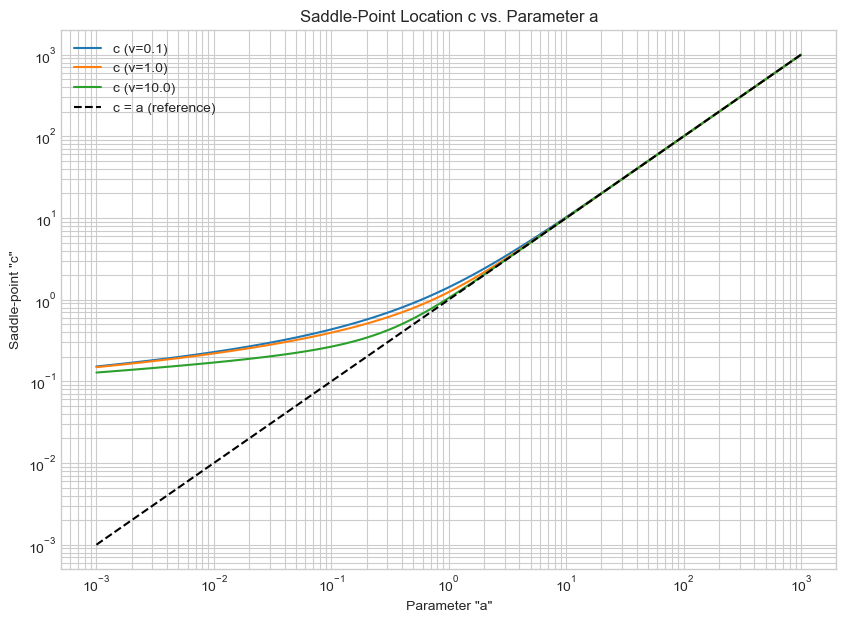

In [4]:
def find_saddle_point_c(a, v):
    """
    Finds the value c > 0 that satisfies the saddle-point condition b_1 = 0.
    Solves the equation: psi(c) + v*c - (log(a) + v*a) = 0
    """
    # The target function whose root we seek
    target_func = lambda c, a_val, v_val: scsp.psi(c) + v_val * c - (np.log(a_val) + v_val * a_val)
    # The derivative of the target function, for Newton's method
    derivative_func = lambda c, a_val, v_val: scsp.polygamma(1, c) + v_val
    
    # We use 'a' as the initial guess, as we proved that c > a.
    # Newton's method is very efficient when the derivative is known.
    sol = scop.root_scalar(
        target_func, 
        args=(a, v), 
        method='newton', 
        x0=a, 
        fprime=derivative_func
    )
    return sol.root

# --- Params for the graph ---
a_values = np.logspace(-3, 3, 100)
v_values = [0.1, 1.0, 10.0] # Разные значения дисперсии

plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(10, 7))

for v in v_values:
    c_values = [find_saddle_point_c(a, v) for a in a_values]
    ax.plot(a_values, c_values, label=f'c (v={v})')

# Line c=a for comparison
ax.plot(a_values, a_values, 'k--', label='c = a (reference)')

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Parameter "a"')
ax.set_ylabel('Saddle-point "c"')
ax.set_title('Saddle-Point Location c vs. Parameter a')
ax.legend()
ax.grid(True, which="both", ls="-")
plt.show()

**Analysis of the Results:**

The plot generated by the code (Figure 1) visually confirms our theoretical findings:

1.  **Validity:** All curves representing $c$ lie strictly above the reference line $c=a$, which empirically demonstrates that the method is robust and the condition $c>0$ is always met.
2.  **Asymptotic Behavior:** As $a$ becomes large, the value of $c$ approaches $a$. This is expected, as for large arguments the terms $\psi^{(0)}(c)$ and $\ln(a)$ in the saddle-point equation become less significant compared to the linear terms $vc$ and $va$, leading to the approximation $c \approx a$.
3.  **Influence of Variance:** For a fixed $a$, a larger variance $v$ results in a value of $c$ that is closer to $a$. This is also consistent with the saddle-point equation, where a large $v$ amplifies the linear terms, diminishing the relative impact of the non-linear digamma function.

Therefore, the choice of $c$ that satisfies the saddle-point condition is not only optimal for accuracy but also mathematically robust, guaranteeing a valid integration path for all relevant parameters. This completes our derivation of a highly accurate, semi-analytical approximation. The only drawback is that the standard root-finding function is not vectorized, but we can overcome this by implementing the Newton method for a fixed number of iterations.


In [5]:
def find_saddle_point_c_vectorized(a_array, v, n=4):
    """
    Finds the value c > 0 that satisfies the saddle-point condition b_1 = 0.
    Solves the equation: psi(c) + v*c - (log(a) + v*a) = 0
    """    
    # Initial guess
    c = a_array + 1/(7.5 + 25*(a_array - 0.85*np.sqrt(a_array)))
    loop_const = np.log(a_array) + v * a_array 
    for _ in range(n):
        # The target function whose root we seek
        f = scsp.psi(c) + v * c - loop_const
         # The derivative of the target function, for Newton's method
        fp = scsp.polygamma(1, c) + v
        # Newton's method
        c = c - f / fp
    return c

Finally the approximate Laplace Transform of LogNormal variable function is:


In [6]:
def LTLN_approx_SP(u,v):
    a=np.atleast_1d(np.real(scsp.lambertw(u*v))/v)
    lna=np.log(a)
    c=find_saddle_point_c_vectorized(a,v)
    lgc=scsp.loggamma(c)
    pg0c=scsp.polygamma(0, c)
    pg1c=scsp.polygamma(1, c)
    b0=lgc-a*c*v + c**2*v/2 - c*lna
    b1=pg0c-lna+v*(c-a) #as we find c appoximately this expression is no exactly zero
    four_b2=2.*(pg1c+v)
    return np.exp(b0 - b1**2/four_b2)/np.sqrt(np.pi*four_b2)

#### Performance of the Saddle-Point Approximation (Large `a` Regime)
The validation confirmed the theoretical strengths and weaknesses of the method:
1.  **Asymptotic Correctness:** The approximation is highly accurate in its designed regime of large $u$ (and thus large $a$). For $u \in [100, 1000]$, the accuracy ratio is typically between 0.99 and 0.999, demonstrating its validity.
2.  **Mid-Range Performance:** For non-asymptotic values of $u$ (e.g., $u \in [0.01, 1.0]$), the formula provides a reasonable accuracy, with errors typically in the range of -9% to +2%. This is often sufficient for applications requiring rapid estimation.
3.  **Influence of Variance:** Accuracy is highest for moderate variance ($v \approx 1$). The error increases as $v$ becomes very large or very small, as the true integrand deviates more significantly from the approximating Gaussian profile.

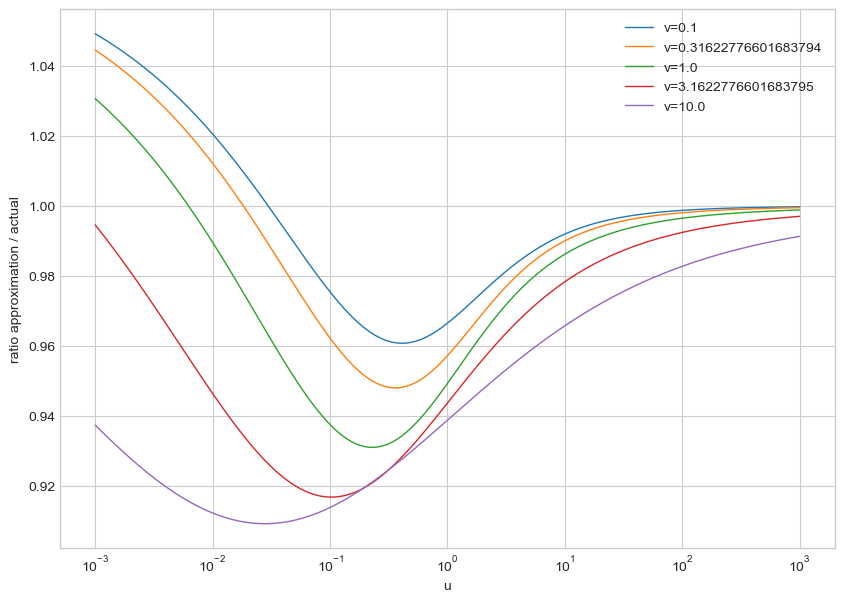

In [7]:
u_r=np.logspace(-3,3,201)
v0=np.logspace(-1,1,5)
fig, ax = plt.subplots(figsize=(10, 7))
for i,v in enumerate(v0):
    ratio=LTLN_approx_SP(u_r,v)/LTLN_true(u_r,v)
    plt.plot(u_r,ratio,linewidth=1, color=f'C{i}',label=f'v={v}')
plt.xlabel('u')

plt.ylabel('ratio approximation / actual')
plt.xscale('log')
#plt.yscale('log')
plt.legend(loc='upper right')
plt.show()

### 6. Asymptotic Approximation for Small `a`

The saddle-point approximation derived previously provides high accuracy for large values of the parameter `a`. However, its performance degrades as `a` approaches zero. In this section, we develop an alternative asymptotic expansion specifically tailored for the regime where $a \to 0$.

Our starting point is again the integral representation:
$$
L(a,v) = \frac{\exp\left( -\frac{v a^2}{2} \right)}{2\pi} \int_{-\infty}^{\infty} \frac{\Gamma(a+i t)}{a^{a+i t}} e^{-v t^2/2} dt
$$
The core idea rests on the behavior of the two main components of the integrand as $a \to 0$.

1.  **The Gamma Function Term:** The term $f(t) = \frac{\Gamma(a+i t)}{a^{a+i t}}$ becomes highly concentrated around $t=0$. Its real part behaves like a sharply peaked function, tending towards a scaled Dirac delta function as $a \to 0$. This is because for small $a$, $|\Gamma(a+it)|$ is significant only for very small $t$, and the term $a^{-it} = e^{-it\ln(a)}$ oscillates with infinitely increasing frequency as $a \to 0$.
2.  **The Gaussian Term:** The term $g(t) = e^{-v t^2/2}$ is a smooth, slowly varying function, especially in the vicinity of $t=0$ where the other term is concentrated.

This structure suggests a powerful approximation strategy: since the Gamma function term effectively samples the Gaussian term only at points extremely close to $t=0$, we can replace the Gaussian term with its Taylor series expansion around $t=0$:
$$
e^{-v t^2/2} = 1 - \frac{v t^2}{2} + \frac{v^2 t^4}{8} - \dots
$$
Substituting this series into the integral and assuming the validity of term-by-term integration, we can construct an asymptotic series for $L(a,v)$ in powers of $v$.

#### **The Zeroth-Order Term**

Let us focus on the first and most dominant term of this series, which corresponds to replacing $e^{-v t^2/2}$ with its value at $t=0$, which is 1. The zeroth-order approximation, which we denote as $L_0(a,v)$, is given by:
$$
L_0(a,v) = \frac{\exp\left( -\frac{v a^2}{2} \right)}{2\pi} \int_{-\infty}^{\infty} \frac{\Gamma(a+i t)}{a^{a+i t}} dt
$$
The remaining integral, $I_0(a) = \int_{-\infty}^{\infty} \frac{\Gamma(a+i t)}{a^{a+i t}} dt$, can be computed using a connection to the Mellin transform.

Recall our analysis from the previous section, where we expressed the integral in the complex plane:
$$
I(a,v) = -i \int_{a-i\infty}^{a+i\infty} a^{-z} \Gamma(z) e^{\frac{v}{2}(z-a)^2} dz
$$
If we remove the Gaussian term by setting $v=0$ (which is equivalent to taking the first term of the Taylor series), our integral $I_0(a)$ becomes:
$$
I_0(a) = -i \int_{a-i\infty}^{a+i\infty} a^{-z} \Gamma(z) dz
$$
This integral is directly related to the inverse Mellin transform. The inverse Mellin transform of a function $M(s)$ is defined as:
$$
f(x) = \frac{1}{2\pi i} \int_{c-i\infty}^{c+i\infty} x^{-s} M(s) ds
$$
In our case, the variable is $a$, the integration variable is $z$, and the function being transformed is $M(z) = \Gamma(z)$. The integral can be rewritten as:
$$
\int_{a-i\infty}^{a+i\infty} a^{-z} \Gamma(z) dz = 2\pi i \cdot \left( \frac{1}{2\pi i} \int_{a-i\infty}^{a+i\infty} a^{-z} \Gamma(z) dz \right)
$$
The term in the parentheses is the inverse Mellin transform of the Gamma function, evaluated at $a$. It is a standard result that the function whose Mellin transform is $\Gamma(s)$ is $e^{-x}$. Therefore:
$$
\frac{1}{2\pi i} \int_{a-i\infty}^{a+i\infty} a^{-z} \Gamma(z) dz = e^{-a}
$$
Substituting this back, we find the value of our integral $I_0(a)$:
$$
I_0(a) = -i \cdot (2\pi i \cdot e^{-a}) = 2\pi e^{-a}
$$
Finally, we substitute this result into the expression for $L_0(a,v)$:
$$
L_0(a,v) = \frac{\exp\left( -\frac{v a^2}{2} \right)}{2\pi} \cdot (2\pi e^{-a}) = \exp\left( -a - \frac{v a^2}{2} \right)
$$
This remarkably simple formula provides the leading-order approximation for the Laplace transform in the regime where $a$ is small. It serves as the foundation for a new asymptotic series, complementary to the saddle-point approximation. Subsequent terms in this series could be found by evaluating integrals of the form $\int t^{2n} \frac{\Gamma(a+it)}{a^{a+it}} dt$, which correspond to derivatives of the inverse Mellin transform.

### **Derivation of Higher-Order Terms for Small `a`**

To obtain a more accurate approximation, we must compute the subsequent terms in the series expansion:
$$
L(a,v) \approx \frac{\exp\left( -\frac{v a^2}{2} \right)}{2\pi} \left[ I_0(a) - \frac{v}{2} I_2(a) + \frac{v^2}{8} I_4(a) - \dots \right]
$$
where the integrals to be computed are of the form:
$$
I_{2n}(a) = \int_{-\infty}^{\infty} t^{2n} \frac{\Gamma(a+i t)}{a^{a+i t}} dt
$$
A direct calculation is difficult. However, we can evaluate these integrals by recognizing that multiplication by $t^{2n}$ in the time domain corresponds to differentiation in the frequency (or conjugate) domain.

An efficient path is to use the integral representation of the Gamma function within the integral for $I_{2n}(a)$.
From known representation of Gamma function as Mellin transform of the exponent we have:
$$\frac{\Gamma(s)}{a^s}\;=\;\int_{0}^{\infty} x^{s-1}\,e^{-a x}\,dx,\qquad \Re(s)>0,\;\Re(a)>0.$$
so
$$\frac{\Gamma(a + i t)}{a^{\,a + i t}}\;=\;\int_{0}^{\infty}x^{\,a + i t - 1}\,e^{-a x}\,dx.$$
Hence
$$
I_{2n}(a) = \int_{-\infty}^{\infty} t^{2n} \left(\int_0^\infty x^{a+it-1}e^{-ax}dx\right) dt
$$
Changing the order of integration, which is permissible here:
$$
I_{2n}(a)= \int_0^\infty x^{a-1}e^{-a x} \left(\int_{-\infty}^\infty t^{2n} e^{it\ln x} dt\right) dx
$$
The inner integral is the Fourier transform of $t^{2n}$, which is a derivative of the Dirac delta function:
$$
\int_{-\infty}^\infty t^{2n} e^{itk} dt = 2\pi i^{2n} \delta^{(2n)}(k) = 2\pi (-1)^n \delta^{(2n)}(k)
$$
Here, the frequency variable is $k = \ln(x)$. So the outer integral becomes:
$$
I_{2n}(a) = 2\pi (-1)^n \int_0^\infty x^{a-1}e^{-a x} \delta^{(2n)}(\ln(x)) dx
$$



To evaluate the integral involving the delta derivative, we change variables to $y = \ln(x)$, which means $x=e^y$ and $dx=e^y dy$. The delta function becomes $\delta^{(2n)}(y)$, centered at $y_0=0$.
Using the sifting property $\int f(y)\delta^{(2n)}(y)dy = (-1)^{2n} f^{(2n)}(0) = f^{(2n)}(0)$, our integral becomes:
$$
I_{2n}(a) = 2\pi (-1)^n \left[ \frac{d^{2n}}{dy^{2n}} \left( (e^y)^{a-1} e^{-ae^y} \cdot e^y \right) \right]_{y=0} = 2\pi (-1)^n \left[ \frac{d^{2n}}{dy^{2n}} \,e^{a y-a e^y} \right]_{y=0}
$$


### **Final Representation of the Asymptotic Series for Small `a`**

The analysis of the integral for small `a` via Taylor expansion of the Gaussian term leads to a systematic asymptotic series. By correctly evaluating the moments $\int t^{2n}(\dots)dt$ through differentiation in the Fourier domain, we can express the Laplace transform as the exact sum of this series.

Let's start from the proven identity:
$$
\int_{-\infty}^{\infty} t^{2n} \frac{\Gamma(a+it)}{a^{a+it}} dt = 2\pi(-1)^n \left[ \frac{d^{2n}}{dy^{2n}} e^{a y-a e^y}\right]_{y=0}
$$
The full Laplace transform is given by the series:
$$
L(a,v) = \frac{\exp\left( -va^2/2 \right)}{2\pi} \sum_{n=0}^{\infty} \frac{(-v/2)^n}{n!} \left( \int_{-\infty}^{\infty} t^{2n} \frac{\Gamma(a+it)}{a^{a+it}} dt \right)
$$
Substituting our identity for the integral:
$$
L(a,v) = \frac{\exp\left( -va^2/2 \right)}{2\pi} \sum_{n=0}^{\infty} \frac{(-v/2)^n}{n!} \left( 2\pi(-1)^n \left[ \frac{d^{2n}}{dy^{2n}} e^{a y-a e^y}\right]_{y=0} \right)
$$
The factors of $2\pi$ cancel. The sign terms combine: $(-1)^n (-1)^n = (-1)^{2n} = 1$. This leads to the final, compact formula:

$$
\boxed{
L(a,v) = \exp\left( - \frac{va^2}{2} \right) \sum_{n=0}^{\infty} \frac{(v/2)^n}{n!} \left[ \frac{d^{2n}}{dy^{2n}} e^{ay-ae^y} \right]_{y=0}
}
$$

**Significance of this form:**

*   **Correctness:** This formula is mathematically rigorous and directly derived from first principles, avoiding the pitfalls of applying pre-existing identities for other mathematical objects. It correctly captures the signs of all terms in the series.
*   **Computability:** It provides a clear procedure for calculating any coefficient in the series. One simply needs to compute the derivatives of the function $K(y,a) = e^{ay-ae^y}$ at $y=0$. While this can be done symbolically for the first few terms (as we did manually), it can also be implemented using algorithmic differentiation for higher-order terms.
*   **Asymptotic Nature:** This representation makes it clear that we are dealing with an asymptotic series in powers of $v$. For a fixed $a$, the derivatives $\frac{d^{2n}}{dy^{2n}}(\dots)$ grow extremely rapidly with $n$, ensuring that the series diverges for any $v \neq 0$. This series is divergent but provides an excellent approximation for small `a` when truncated at an optimal point, particularly for smaller values of variance `v`.

#### Performance of the Asymptotic Series (Small `a` Regime)
The series derived for small `a` provides a complementary tool. As an asymptotic series, it must be truncated optimally to avoid divergence. Numerical experiments show it performs well for small `a`, especially when the variance `v` is also small (e.g., $v < 0.5$). For larger `v`, more terms are needed, and the region of convergence shrinks, making it less practical.

### 7. Conclusion

This section has provided a comprehensive toolkit for analyzing and computing the Laplace transform of a lognormal random variable. The primary contributions are threefold:

1.  A **robust numerical method** based on a dual-domain integral representation. By adaptively switching between spatial and frequency domains, this method overcomes numerical stability issues and serves as a reliable "gold standard" for high-precision computation.

2.  A **novel semi-analytical approximation** derived using the saddle-point method. This closed-form solution offers excellent accuracy for large transform arguments and provides deep theoretical insight into how the transform depends on its underlying parameters.

3.  An **asymptotic series** for the small-argument regime. This formula is complementary to the saddle-point approximation and is effective when both the argument `a` and variance `v` are small.

These approaches are not competing but complementary. Together, they offer a powerful and flexible set of tools for tackling a classic and important problem in applied probability theory, providing options for high-precision calculation, rapid estimation, and theoretical analysis.